In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from PIDA_class import loaddata
from  ana_tools import *
import plotly.graph_objects as go


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })


from pida_functions import *

In [2]:
    
df = loaddata("data/pida_new_full.root", entry_stop=None, forceit=False)

data/pida_new_full.root loaded parquet


In [3]:
dftrkg4 = df

In [4]:
# def getbestof(df:pl.DataFrame ) -> pl.DataFrame:
#     df:pl.DataFrame
#     dftmp = df.group_by(selection_events(), maintain_order=True).agg(
#         pl.col('^trkcalo_.*$').sum(),
#         pl.col('^trknhits_.*$').sum(),
#         pl.col('^allcalo_.*$').last(),
#         pl.col('^nallhits_.*$').last(),
#     ).with_columns(
#         otherallcalo_planes_U = pl.col('allcalo_planes_U') - pl.col('trkcalo_planes_U'),
#         otherallcalo_planes_V = pl.col('allcalo_planes_V') - pl.col('trkcalo_planes_V'),
#         otherallcalo_planes_W = pl.col('allcalo_planes_W') - pl.col('trkcalo_planes_W'),
#         othernallhits_planes_U = pl.col('nallhits_planes_U')-pl.col('trknhits_planes_U'),
#         othernallhits_planes_V = pl.col('nallhits_planes_V')-pl.col('trknhits_planes_V'),
#         othernallhits_planes_W = pl.col('nallhits_planes_W')-pl.col('trknhits_planes_W'),
#     ).select(
#         pl.col('run'),
#         pl.col('subrun'),
#         pl.col('event'),
#         pl.col('^other.*$')
#     )
#     df = df.join(dftmp, on=selection_events(), how='inner')
#     allkeys = df.columns
#     allkeys = [ k.strip("_U") for k in allkeys if "_U" in k]
#     for k in allkeys:
#         vartomax = "trknhits_planes"
#         if "trkpid" in k:
#             vartomax='trkpidndf'
#         if k.startswith('allcalo'):
#             vartomax='nallhits_planes'
#         if k.startswith('other'):
#             vartomax='othernallhits_planes'
        
#         df = df.with_columns(
#             pl.when(
#                 (pl.col(f'{vartomax}_W') >= pl.col(f'{vartomax}_V')) & 
#                 (pl.col(f'{vartomax}_W') >= pl.col(f'{vartomax}_U'))  
#                 ).then(
#                     pl.col(f'{k}_W')
#                 ).otherwise(
#                     pl.when(
#                         (pl.col(f'{vartomax}_V') >= pl.col(f'{vartomax}_U'))  
#                     ).then(
#                         pl.col(f'{k}_V')
#                     ).otherwise(
#                         pl.col(f'{k}_U')
#                     )
#                 ).alias(f"{k}_B")
#         )
#     return df

dftrkg4 = getbestof(dftrkg4)

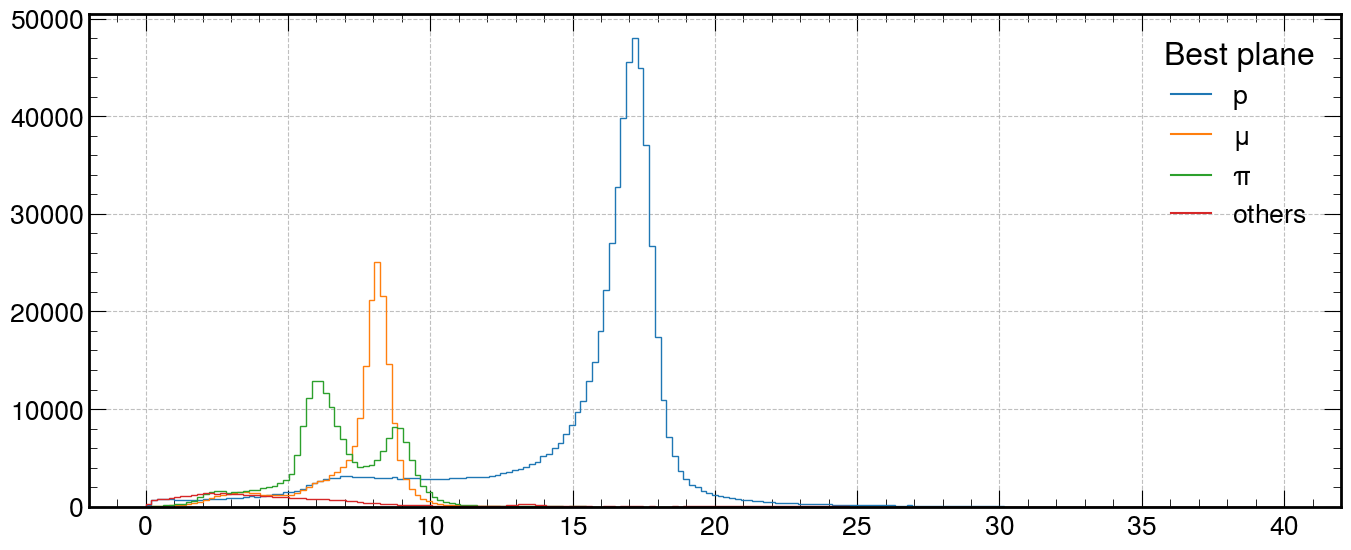

In [5]:
from matplotlib.lines import Line2D

def plot_pid(df:pl.DataFrame,
            plane="B",
            pida = "trkpidpida",
            actual_variable = None,
            pdg=2212,
            binspid = np.linspace(0,40,200),
            notthispdg=False,
            threshold_pnc = 0.85,
            ShowersAndTracks=False,
            onlyShower=False,
            onlycontained=True,
            label="",
            onlyselected=True,
            **kwargs_hist,
            ):
    
    title = f'Plane {plane}'
    if plane=="B":
        # df = getbestof(df, 'trkg4pdg_planes')
        # df = getbestof(df, 'trkpidpida')
        # df = getbestof(df, 'trkpurity_planes')
        # df = getbestof(df, 'trkcompleteness_planes')
        title = 'Best plane'

    if onlyselected and 'selected' in df.columns:
        df = df.filter(
            pl.col('selected')
        )
    trkpdg = f"trkg4pdg_planes_{plane}"
    if (pdg != -1):
        if (notthispdg):
            df = df.filter(pl.col(trkpdg).abs()!=pdg)
        else:
            df = df.filter(pl.col(trkpdg).abs()==pdg)
        particlename = particle.Particle.from_pdgid(pdg).latex_name
        particlename = particlename.strip("^{+}")
        particlename = particlename.strip("^{-}")
    else:
        df = df.filter(
            pl.col(trkpdg).abs()!=2212,
            pl.col(trkpdg).abs()!=211,
            pl.col(trkpdg).abs()!=13,
        )
        particlename='others'
        
    df = df.filter(
        pl.col(f'trkpurity_planes_{plane}') > threshold_pnc,
        pl.col(f'trkcompleteness_planes_{plane}') > threshold_pnc,
        (ShowersAndTracks) | (pl.col('trkPFPIsTrack')),
        (not onlyShower) | ~(pl.col('trkPFPIsTrack')),
        ((not onlycontained) | pl.col(f'trkIsContained'))
    )
    if notthispdg:
        label = r'not ${{{}}}$'.format(particlename) + label
    else:
        label = r'${{{}}}$'.format(particlename) + label
        
    pida_p = f"{pida}_{plane}"
    if pida_p not in df.columns:
        pida_p = pida

    if actual_variable is not None:
        data = actual_variable(df)
    else:
        data = df[pida_p]
    plt.hist(data, binspid, histtype='step',label=label, **kwargs_hist)
    # Create new legend handles but use the colors from the existing ones
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) for h in handles]
    
    plt.legend(title = title, handles=new_handles, labels=labels)
    return

plt.figure()
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=2212)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=13)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=211)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=-1)
# plt.yscale('log')

In [6]:
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


minPNC = [0, 0.5*0.5, 0.8*0.8, 0.9*0.9]
dfall_v = []
print("Total events:", len(dfall.group_by(selection_events()).agg()))
for minV in minPNC:
    if minV == 0:
        minV = -1e12
    dfall_enough_pnc = dfall.group_by(selection_events()).agg(
        ((pl.col('trkg4pdg_planes_B').abs() == 13) & (pl.col('trkg4mother_planes_B')==0) & (pl.col('pnc') > minV) & (pl.col('trklen')>0)).any().alias('hasmu')
    )
    print(len(dfall_enough_pnc), len(dfall_enough_pnc.filter(~pl.col('hasmu'))), len(dfall_enough_pnc.filter(~pl.col('hasmu')))/len(dfall_enough_pnc))

    dfall_enough_pnc = dfall_enough_pnc.filter(
        pl.col('hasmu')
    ).select(selection_events())

    dfall_v.append(dfall.join(dfall_enough_pnc, on=selection_events()).sort(selection_events()))
    print(len(dfall_v[-1]))

Total events: 472153
472153 30007 0.06355355149707828
1737994
472153 33227 0.07037337473234312
1707816
472153 63258 0.13397775721005692
1538273
472153 105574 0.2236012479005746
1331821


In [50]:

def plot_purity_completeness(df:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             skipplot=False,
                             ):
    
    dfall = df.group_by(selection_events()).agg(
        pl.all().last()
    )
    df = df.filter(
        pl.col('selected_mu')
    )
    dfcheck = df.group_by(selection_events()).agg(
        pl.col('enu_truth').len().alias('n')
    ).filter(
        pl.col('n')>1
    )
    if len(dfcheck)>0:
        raise Exception("WTF?!?!")
    dffiltered = df.filter(
        ismu()
    )
    if binse is None:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfall['enu_truth'], bins=binse)
    bn, b = np.histogram(df['enu_truth'], bins=binse)
    bnfiltered, b = np.histogram(dffiltered['enu_truth'], bins=binse)

    completeness = np.divide(bn, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness
    if skipplot:
        return val, b

    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    return val, b

def print_ratio(a, b):
    try:
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
    except Exception as error:
        # print(error)
        a=len(a.group_by(selection_events()).agg())
        b=len(b.group_by(selection_events()).agg())
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
def plot_ratio(data, bins, var='enu_truth', general_filter=None, thefilter=None, plotnevents=False):
    if general_filter is not None:
        data = general_filter(data)
    if thefilter is None:
        def thefilter(df):
            return df.filter(ismu())
    data_filtered = thefilter(data)
    bt, b = np.histogram(data[var], bins=bins)
    bm, b = np.histogram(data_filtered[var], bins=bins)
    bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
    # print(sum(bm),sum(bt))
    plt.hist(b[:-1], b, weights=bratio, histtype='step')
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bt, alpha=0.2, log=False)
        # ax2.hist(b[:-1], b, weights=bm, alpha=0.2, log=False)
        ax2.set_ylabel(rf'n events')
        ax2.grid(False)
    plt.sca(ax)

In [55]:
from typing import List
# I tried 1e3 cut, virtually no change...
# def create_mucandidates(df):
#     dfselected = df.sort('trklen').filter(
#         pl.col('trkPFPIsTrack'),
#         pl.col('trklen')>0
#     ).group_by(selection_events(), maintain_order=True).agg(
#         pl.col('trkId').last(),
#     ).with_columns(
#         pl.lit(True).alias("selected")
#     )
#     df = df.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
#         pl.col('selected').fill_null(False)
#     ).group_by(selection_events(), maintain_order=True).agg(
#         pl.len().alias('noptions'),
#         pl.all()
#     ).explode(
#         pl.all().exclude(selection_events('noptions'))
#     )
#     return df

# def get_dist_vtx(df:pl.DataFrame):
#     return df.with_columns(
#         (1/(
#             (pl.col('trkstartx')- pl.col('recovtxx'))**2 + 
#             (pl.col('trkstarty')- pl.col('recovtxy'))**2 + 
#             (pl.col('trkstartz')- pl.col('recovtxz'))**2 
#         ).sqrt()).alias('overdistvtx'),
#     )
# def get_options(df:pl.DataFrame):
#     df = df.drop('noptions')
#     df = df.group_by(selection_events(), maintain_order=True).agg(
#         pl.len().alias('noptions'),
#         pl.all()
#     ).explode(
#         pl.all().exclude(selection_events('noptions'))
#     )
#     return df
    
# def get_biggest(df:pl.DataFrame,
#                 tailv:dict={'trklen':1,
#                        'trkmomllhd':2,
#                        'trkPFPScoreIsTrack':2,
#                        'distvtx':2,
#                       }
#                 ):
#     listsort = [ k for k in  tailv.keys()]
#     listvars = [ f'big_{k}' for k in  tailv.keys()]
#     df = df.drop(listvars)
#     for var, varsort, tt in zip(listvars, listsort, tailv.values()):
#         if varsort not in df.columns:
#             continue
#         dfsel = df.sort(varsort,).group_by(selection_events(), maintain_order=True).agg(
#             pl.col('trkId').tail(tt),
#         ).explode(
#             'trkId'
#         ).with_columns(
#             pl.lit(True).alias(var)
#         )
#         df = df.join(dfsel, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
#             pl.col(var).fill_null(False)
#         )
#     return df
# def get_rest(df:pl.DataFrame, restpidcut = 13):
    
#     df = get_dist_vtx(df)
#     df = get_options(df)
#     df = df.filter(~((pl.col('trkpidpida_B')>=restpidcut) & (pl.col('noptions')>1)))
#     df = get_options(df)
#     firsttails = {
#        'trklen': 1,
#        'trkmomllhd': 1,
#        'trkPFPScoreIsTrack': 1,
#        'overdistvtx': 1,
#     }
#     df = get_biggest(df, firsttails)


#     dffirst = df.with_columns(
#         pl.when(((pl.col('big_trklen')) & (pl.col('big_trkPFPScoreIsTrack')) )).then(True).otherwise(False).alias('selected')
#     ).filter(
#         pl.col('selected')
#     ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
#         pl.col('trkId').last()
#     )

#     secondtails = {
#        'trklen': 1,
#        'trkmomllhd': 2,
#        'trkPFPScoreIsTrack': 2,
#        'overdistvtx': 2,
#     }
#     df = df.join(dffirst, on=selection_events(), how='anti')

#     df = get_biggest(df, secondtails)
#     df = get_options(df)

#     dfsecond = df.with_columns(
#         pl.when(((pl.col('big_trklen')) & pl.col('big_trkPFPScoreIsTrack')  )).then(True).otherwise(False).alias('selected')
#     ).filter(
#         pl.col('selected')
#     ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
#         pl.col('trkId').last()
#     )

#     dfselected = pl.concat([dffirst, dfsecond], how='vertical')
    
#     return dfselected

# def getfineselection(dforiginal:pl.DataFrame,
#                      firstselect={"trklen":1,
#                                   "trkmomllhd":3,
#                                   "trkPFPScoreIsTrack":3},
#                      ):

#     df = dforiginal.filter(
#         (pl.col('trklen')>10),
#     )

#     df = get_options(df)
#     df = df.filter(
#         ~((pl.col('trkmomllhd') > 4) & (pl.col('trklen')<50) & pl.col('noptions')>=2)
#     )
#     df = get_options(df)
#     df = df.filter(
#         (pl.col('trkmomllhd')> 2.1*1e-3*pl.col('trklen')+0.005) | (pl.col('noptions')==1),
#     )
#     df = get_biggest(df,firstselect)
#     dfselected = df.with_columns(
#         pl.when(((pl.col('big_trklen')) & (pl.col('big_trkmomllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('big_trkPFPScoreIsTrack')))).then(True).otherwise(False).alias('selected')
#     ).filter(
#         pl.col('selected')
#     ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
#         pl.all().last()
#     )

#     dfselected = dfselected.select(selection_events(['trkId']))
    
#     return dfselected

# def create_mucandidates_2(df:pl.DataFrame,
#                           cut=1.7e3,
#                           pidacut=13,
#                           pidacut_low=10,
#                           restpidcut=13,
#                           filter_shower=True,
#                           calocut=0, # was 3
#                           calocutpida=0., # was 0.1
#                           calocut_new=1, 
#                           fineselection=True,
#                           firstselect={"trklen":1,
#                                       "trkmomllhd":3,
#                                       "trkPFPScoreIsTrack":3},
#                           afterfine = True,
#                           includeall = True,
#                           ):

#     # if 'allcalo' not in df.columns:
#     #     df = df.group_by(selection_events(), maintain_order=True).agg(
#     #         pl.col('trkcalo_planes_B').sum().alias('allcalo'),
#     #         pl.all()
#     #     ).explode(pl.all().exclude(selection_events('allcalo')))


#     calovariable = "allcalo_planes_B"
#     dforiginal = df.filter(
#         pl.col('trklen')>0
#     )

#     df = get_options(dforiginal)
#     df = df.filter(
#         ~((pl.col('trklen') >= cut) & (pl.col('noptions')>1)),
#     )
#     df = get_options(df)
#     df = df.filter(
#         ~((pl.col(calovariable) >= calocutpida) & (pl.col('trkpidpida_B') > pidacut) & (pl.col('noptions')>1)),
#     )
#     if filter_shower: 
#     #     # Tested: there is only ~4% of tracks tagged as muon here with PxC > 0.36
#         df = get_options(df)
#         df = df.filter(
#         ~((pl.col(calovariable).is_between(0.3,2)) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))
#         )
#         df = get_options(df)
#         df = df.filter(
#         ~((pl.col('trkpidpida_B') < 5) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))# & (pl.col("allcalo")>2))
#         )

#     df = get_options(df)
#     dfallcontained = df.filter(
#         (pl.col(calovariable) >= calocut) & ~(pl.col('trkIsContained')) & (pl.col('noptions')>1)
#     ).group_by(selection_events()).agg(
#     ).with_columns(
#         pl.lit(False).alias('allcontained')
#     )
#     df = df.join(dfallcontained, on=selection_events(), how='left', coalesce=True).with_columns(
#         pl.col('allcontained').fill_null(True)
#     )
#     df = df.filter(
#         ~((pl.col(calovariable) >= calocut_new) & (pl.col('trkIsContained')) & ~(pl.col('allcontained'))),
#     )
#     df = get_options(df)
#     df = df.filter(
#         ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1)),
#     )
#     df = get_options(df)

#     # df = df.filter(
#     #     ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('trkpidpida_B')>=pidacut_low) & (pl.col('noptions')>1)),
#     # )
#     # df = get_options(df)

#     df = df.filter(
#         ~((pl.col(calovariable) >= calocut) & (pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1) & (pl.col('trkpidpida_B')>pidacut_low)),
#     )
#     df = get_options(df)
#     # df = df.filter(
#     #     ~((pl.col(calovariable) >= calocut) & (pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2) & (pl.col('trkpidpida_B')>pidacut_low)),
#     # )
#     df = df.with_columns(
#         pl.lit(True).alias('candidate')
#     )
#     df = get_options(df)
#     if fineselection:
#         dfselected = getfineselection(df, firstselect=firstselect) 
#     else:
#         dfselected = df.sort(
#             'trklen',
#         ).group_by(selection_events(), maintain_order=True).agg(
#             pl.col('trkId').last(),
#         )

#     if afterfine:
#         dfrest = df.join(dfselected, on=selection_events(), how='anti')
#         dfrest = dfrest.filter(pl.col('candidate'))
#         dfrestselected = get_rest(dfrest, restpidcut=restpidcut)
#         dfrestselected = dfrestselected
#         dfselected = pl.concat([dfselected, dfrestselected], how='vertical')

#     dfrest = dforiginal.join(dfselected, on=selection_events(), how='anti')
#     if includeall:
#         dfrest = dfrest.filter(pl.col('trklen')>0)
#         dfrest = get_options(dfrest)
#         dfrest = dfrest.filter(
#             ~((pl.col('trklen') >= cut) & (pl.col('noptions')>1)),
#         )
#         dfrestselected = dfrest.sort('trklen').group_by(selection_events()).agg(
#             pl.col('trkId').last()
#         )
#         dfselected = pl.concat([dfselected, dfrestselected], how='vertical')


#     dfselected = dfselected.with_columns(
#         pl.lit(True).alias("candidate"),
#         pl.lit(True).alias("selected"),
#     )
#     # dforiginal = df
#     dforiginal = dforiginal.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
#         pl.col('candidate').fill_null(False),
#         pl.col('selected').fill_null(False),
#     )
#     return dforiginal
# # plt.hist(b[:-1], b, weights=completeness, histtype='step');

dfmuca = {}
for j, (dfall, tcut) in enumerate(zip(dfall_v, minPNC)):
    dfmuca[tcut] = []
    i =0;dfmuca[tcut].append(0); dfmuca[tcut][i] = create_mucandidates(dfall)
    i+=1;dfmuca[tcut].append(0); dfmuca[tcut][i] = create_mucandidates_2(dfall, fineselection=False, includeall=True, afterfine=False)

    labels = [ i for i in range(len(dfmuca[tcut]))]
    if len(labels)==2:
        labels = ['v09_91_03d00', 'New method']

    plt.figure()
    for i, (dfc, label) in enumerate(zip(dfmuca[tcut], labels)):
        plot_purity_completeness(dfc, type='completeness', label=label, skipplot=True)
        # plt.xscale('log')
        # plt.savefig('c.png', dpi=200)
    plt.figure()
    for i, (dfc, label) in enumerate(zip(dfmuca[tcut], labels)):
        plot_purity_completeness(dfc, type='purity', label=label, skipplot=True)
        # plt.xscale('log')
        # plt.savefig('p.png', dpi=200)
    plt.figure()

    pncs = []*len(dfmuca[tcut])
    pncsbins = 0
    for i, (dfc, label) in enumerate(zip(dfmuca[tcut], labels)):
        v, b = plot_purity_completeness(dfc, type='pnc', label=label, skipplot=True)
        pncs.append(v)
        pncsbins=b
        # plt.xscale('log')
        # plt.savefig('pnc.png', dpi=200)


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

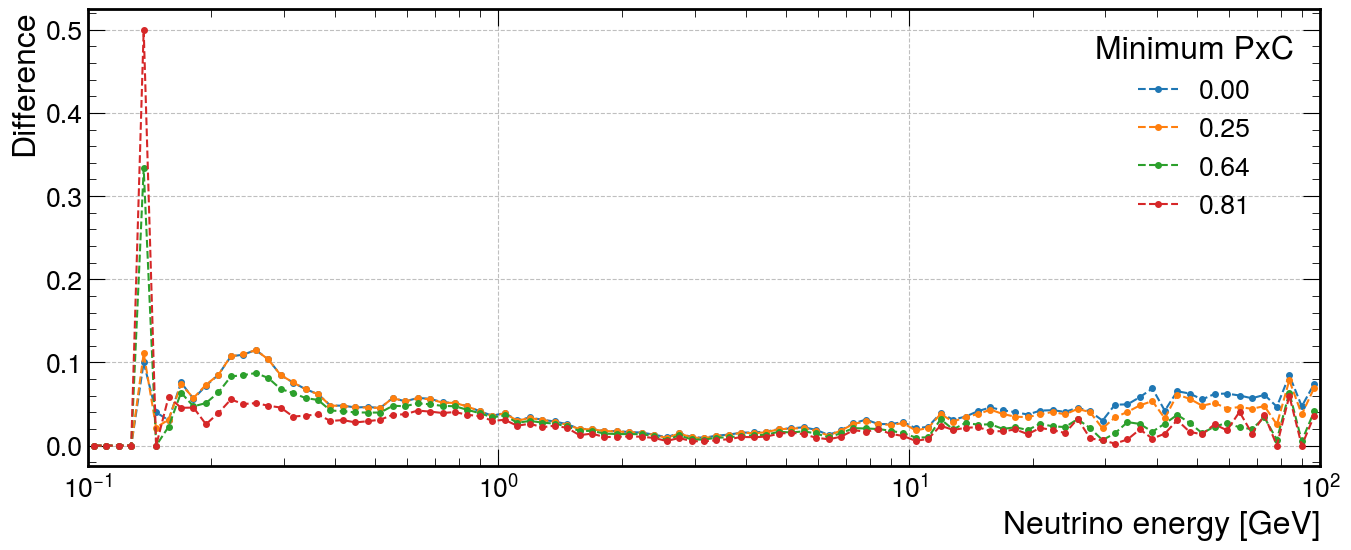

In [14]:

fig = plt.figure()
for j, (dfall, tcut) in enumerate(zip(dfall_v, minPNC)):
    pncs = []*len(dfmuca[tcut])
    pncsbins = 0
    for i, (dfc, label) in enumerate(zip(dfmuca[tcut], labels)):
        v, b = plot_purity_completeness(dfc, type='pnc', skipplot=True)
        pncs.append(v)
        pncsbins=b
    bins_center = (b[:-1] + b[1:])*0.5
    plt.plot(bins_center, pncs[1]-pncs[0], '.--', ms=8, label=f'{tcut:.2f}')
plt.xlabel('Neutrino energy [GeV]')
plt.ylabel('Difference')
plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.legend(title='Minimum PxC')
# plt.savefig('graphs/diff_with_minimums_2.png', dpi=200)

[<Figure size 920x600 with 1 Axes>, <Figure size 920x600 with 1 Axes>]

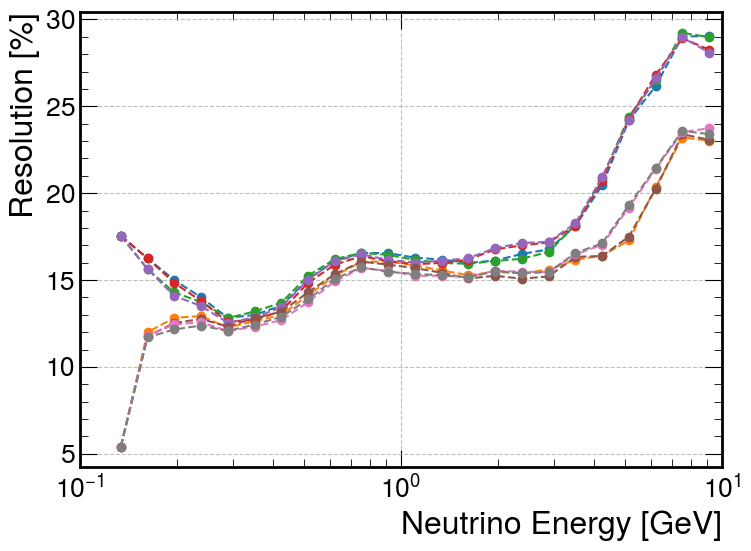

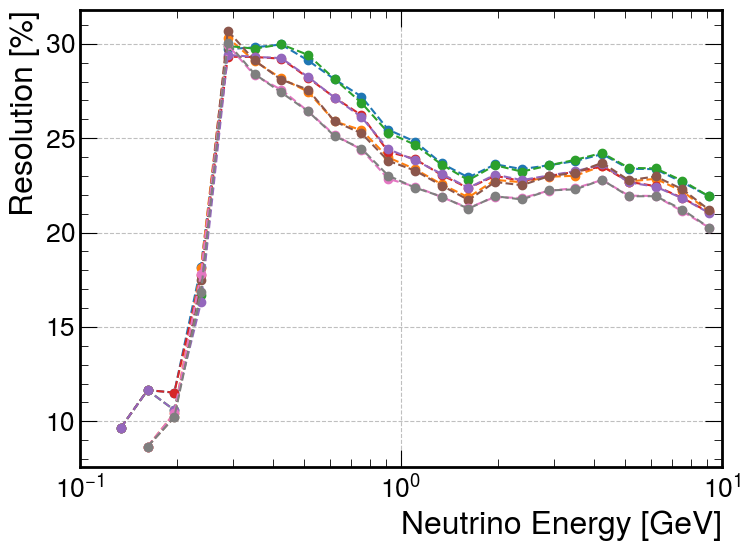

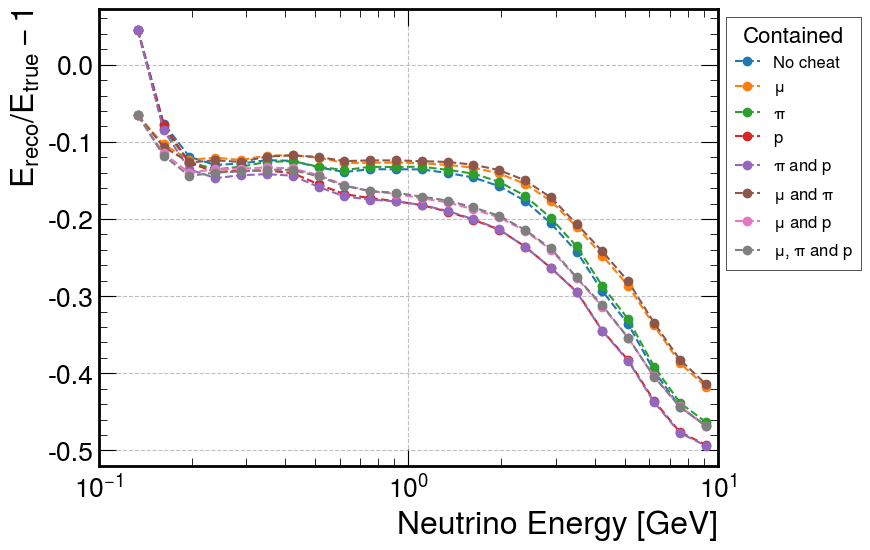

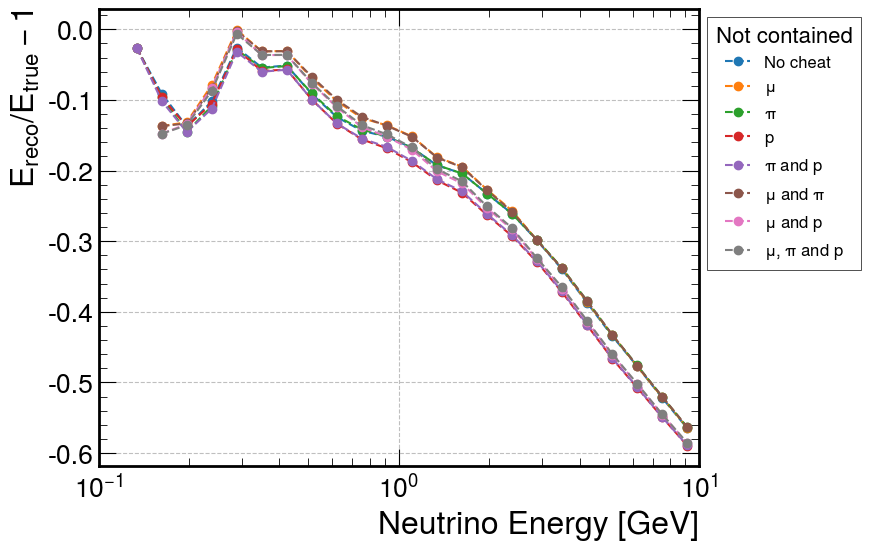

In [ ]:
# tmpargs.pop('fmt',0)
# tmpargs['capsize'] = 2
tmpargs['binsx'] = np.logspace(-1, 1, 25)
tmpargs['figsize'] = (8,6)
tmpargs['nolegend'] = True
plts = the_res_scatter( labels, "std", *dataframes, **tmpargs)
tmpargs['figsize'] = (9.2,6)
tmpargs['nolegend'] = False
the_res_scatter( labels, "mean", *dataframes, **tmpargs)
# plt.ylim(-0.85,0.15)